# Tutorial 5: 10x human tonsil multi slice integration

We evaluated the performance of SMART-MS on a human tonsil dataset. The dataset consists of three tissue sections co-profiled with spatial transcriptomics (RNA) and proteomics (ADT) using the 10x Genomics CytAssist Visium platform.

The raw data can be downloaded from: https://drive.google.com/drive/folders/1pIK6hZCvqHNh0K94-Lgy-CTyfixEUftQ?usp=drive_link.

## Load packages

In [18]:
import os
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import scipy
import warnings
from muon import prot as pt
from smart.utils import pca
from smart.utils import set_seed
from smart.utils import harmony
from smart.utils import MMN_batch
from smart.train import train_SMART
from smart.utils import Cal_Spatial_Net
from matplotlib import pyplot as plt
from scipy.sparse import block_diag
from smart.utils import clustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score, \
    homogeneity_score, mutual_info_score, v_measure_score

set_seed(2025)

warnings.filterwarnings('ignore')
# Environment configuration. SMART pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path, use the command `R RHOME` to find the path.
os.environ['R_HOME'] = '/public/home/cit_wlhuang/.conda/envs/smart/lib/R'

## Load data and  construct spatial neighbour graph 

In [19]:
# read data
file_folds = ['../SMART-main_orignal/datasets/10X_human_tonsil/slice1/','../SMART-main_orignal/datasets/10X_human_tonsil/slice2/','../SMART-main_orignal/datasets/10X_human_tonsil/slice3/']  #please replace 'file_fold' with the download path
name = ["slice1", "slice2", "slice3"]
rna_adatas = {}
adt_adatas = {}
for file_fold, name in zip(file_folds, name):
    adata_omics1 = sc.read_h5ad(file_fold + 'adata_rna.h5ad')
    adata_omics2 = sc.read_h5ad(file_fold + 'adata_adt.h5ad')

    adata_omics1.var_names_make_unique()
    adata_omics2.var_names_make_unique()

    Cal_Spatial_Net(adata_omics1, model="KNN", n_neighbors=6)
    Cal_Spatial_Net(adata_omics2, model="KNN", n_neighbors=6)
    
    rna_adatas[name] = adata_omics1.copy()
    adt_adatas[name] = adata_omics2.copy()


adata_RNA=sc.concat(rna_adatas, label="batch",index_unique="_")
adata_ADT=sc.concat(adt_adatas, label="batch",index_unique="_")

rna_adj  = block_diag([i.uns["adj"] for i in rna_adatas.values()])
adt_adj  = block_diag([i.uns["adj"] for i in adt_adatas.values()])

adata_RNA.uns['edgeList'] = np.array(np.nonzero(rna_adj))
adata_ADT.uns['edgeList'] = np.array(np.nonzero(adt_adj))

The graph contains 25956 edges, 4326 cells.
6.0000 neighbors per cell on average.
The graph contains 25956 edges, 4326 cells.
6.0000 neighbors per cell on average.
The graph contains 27114 edges, 4519 cells.
6.0000 neighbors per cell on average.
The graph contains 27114 edges, 4519 cells.
6.0000 neighbors per cell on average.
The graph contains 27126 edges, 4521 cells.
6.0000 neighbors per cell on average.
The graph contains 27126 edges, 4521 cells.
6.0000 neighbors per cell on average.


In [20]:
adata_RNA.obs['anno']=adata_RNA.obs['final_annot'].map({"tonsillar parenchyma":"tonsillar parenchyma"  ,    
"lymphoid follicle" :"lymphoid follicle"  ,             
"connective & epithelial tissue" :"connective & epithelial tissue"  ,
"connective and epithelial tissue" :"connective & epithelial tissue" ,   
"germinal center":"germinal center" ,                      
"germinal Center":"germinal center" })

## Data pre-processing

In [21]:
# RNA
sc.pp.filter_genes(adata_RNA, min_cells=10)
sc.pp.highly_variable_genes(adata_RNA, flavor="seurat_v3", n_top_genes=5000)
sc.pp.normalize_total(adata_RNA, target_sum=1e4)
sc.pp.log1p(adata_RNA)


adata_RNA.raw=adata_RNA
adata_RNA = adata_RNA[:, adata_RNA.var['highly_variable']]
adata_RNA.obsm['X_pca'] = pca(adata_RNA, n_comps=50)
harmony(adata_RNA,'X_pca',"batch")

# Protein
pt.pp.clr(adata_ADT)
adata_ADT.obsm['X_pca'] = pca(adata_ADT, n_comps=30)
harmony(adata_ADT,'X_pca',"batch")

Neither CUDA nor MPS is available on your machine. Use CPU mode instead.
	Initialization is completed.
	Completed 1 / 20 iteration(s).
	Completed 2 / 20 iteration(s).
	Completed 3 / 20 iteration(s).
	Completed 4 / 20 iteration(s).
	Completed 5 / 20 iteration(s).
Reach convergence after 5 iteration(s).
Neither CUDA nor MPS is available on your machine. Use CPU mode instead.
	Initialization is completed.
	Completed 1 / 20 iteration(s).
	Completed 2 / 20 iteration(s).
	Completed 3 / 20 iteration(s).
	Completed 4 / 20 iteration(s).
	Completed 5 / 20 iteration(s).
	Completed 6 / 20 iteration(s).
	Completed 7 / 20 iteration(s).
	Completed 8 / 20 iteration(s).
	Completed 9 / 20 iteration(s).
	Completed 10 / 20 iteration(s).
	Completed 11 / 20 iteration(s).
	Completed 12 / 20 iteration(s).
	Completed 13 / 20 iteration(s).
	Completed 14 / 20 iteration(s).
	Completed 15 / 20 iteration(s).
Reach convergence after 15 iteration(s).


## UMAP visualizations

UMAP visualizations of three human tonsil slices using PCA features of RNA or ADT before and after Harmony correction.

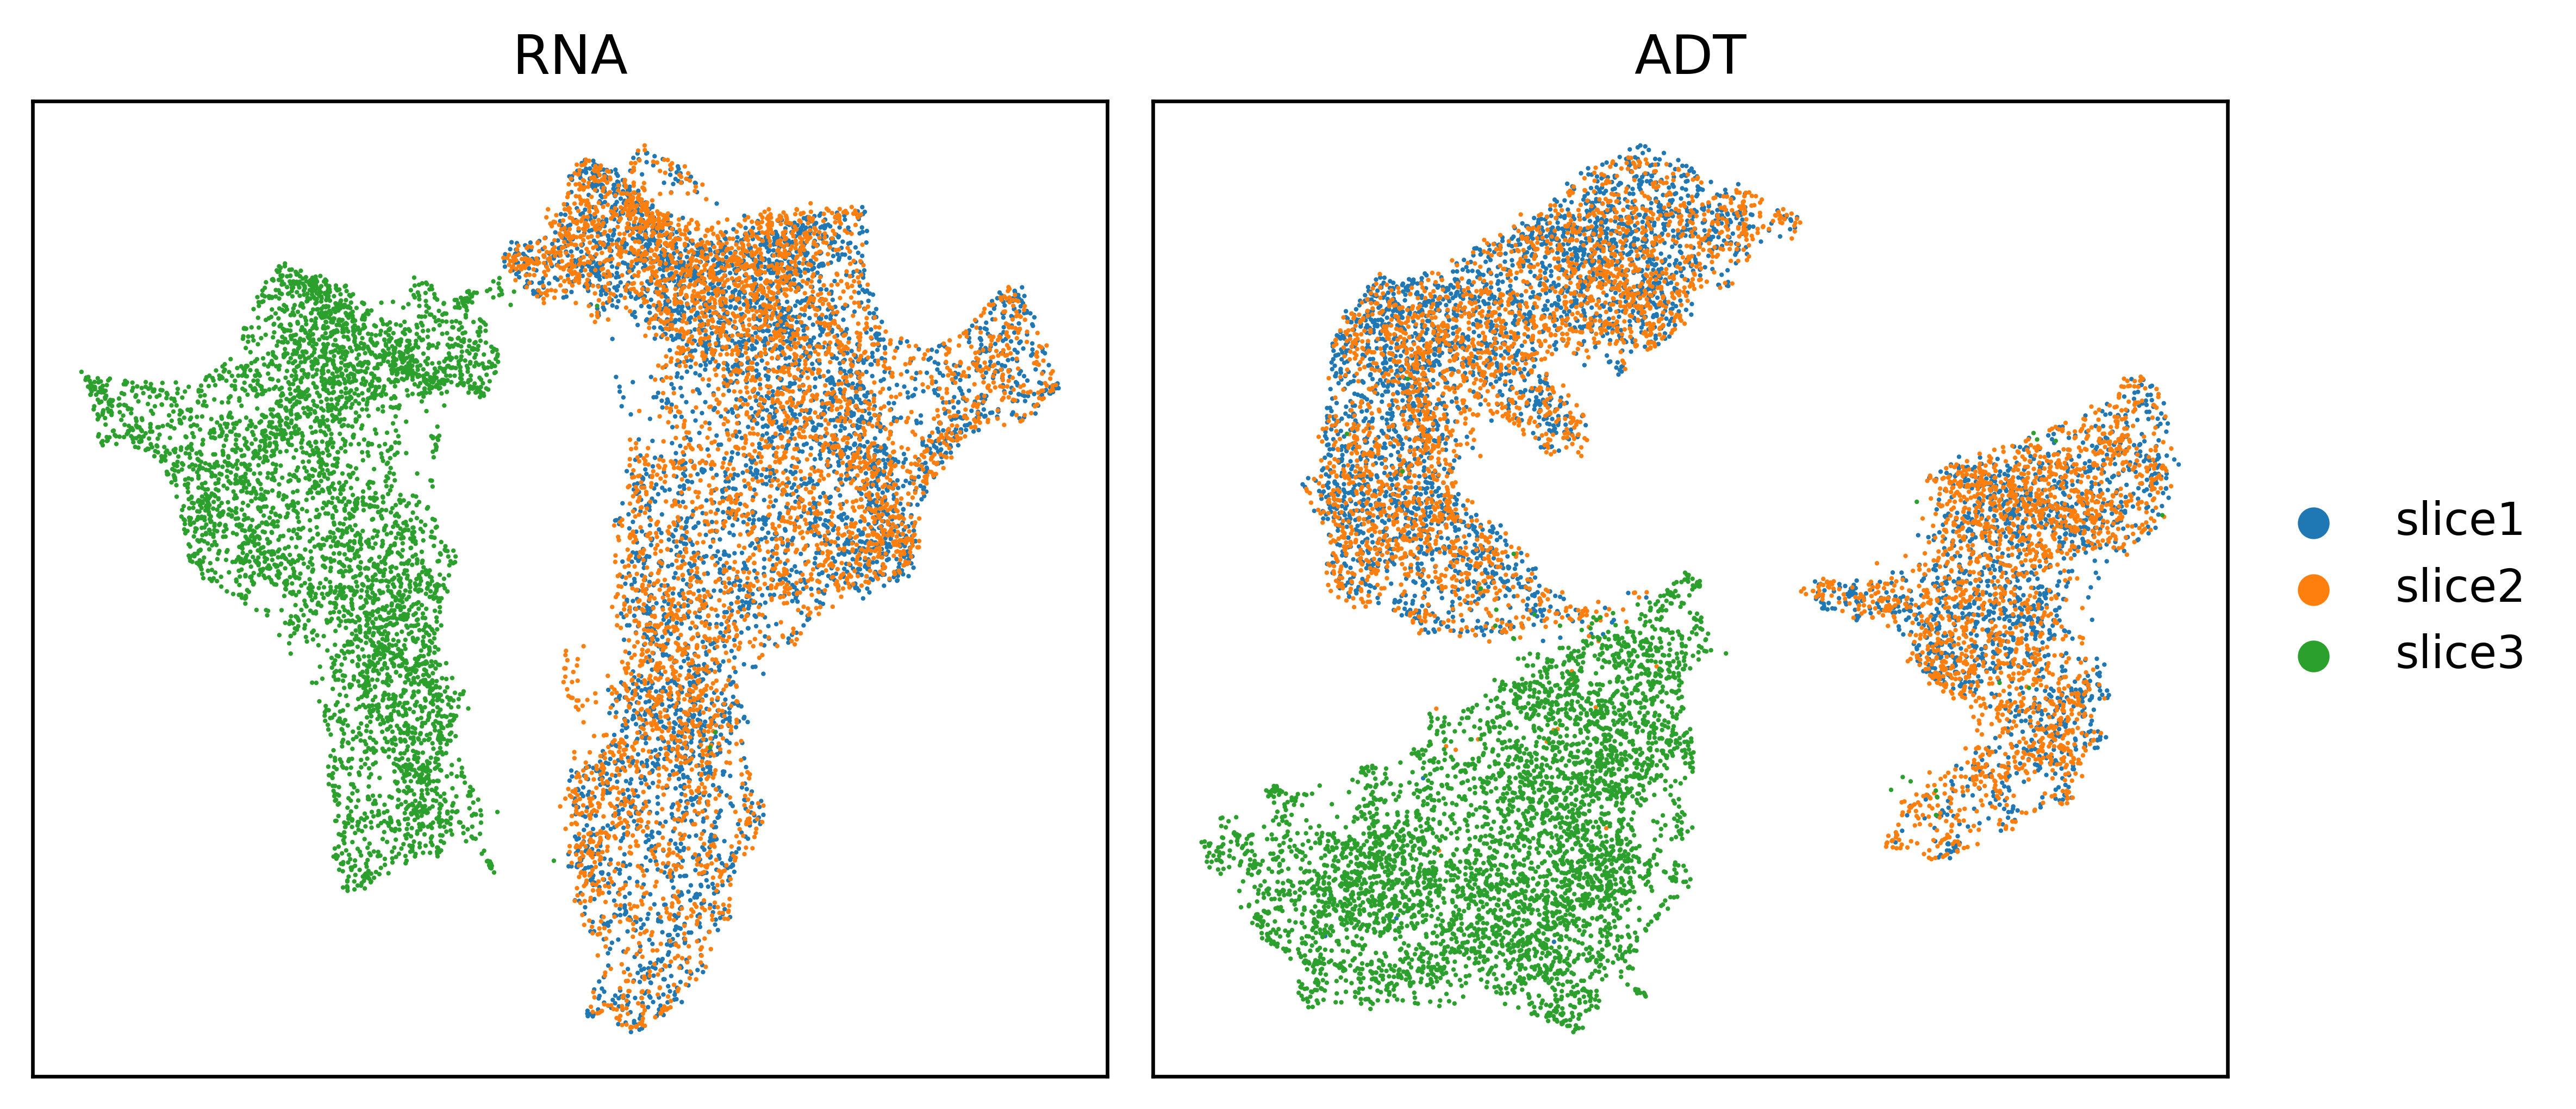

In [22]:
fig, ax_list = plt.subplots(1, 2, figsize=(8, 3.5),dpi=600)
sc.pp.neighbors(adata_RNA, use_rep='X_pca', n_neighbors=10)
sc.tl.umap(adata_RNA)
sc.pl.umap(adata_RNA, color='batch', ax=ax_list[0], title='RNA', s=4 ,show=False)
ax_list[0].get_legend().remove()
sc.pp.neighbors(adata_ADT, use_rep='X_pca', n_neighbors=10)
sc.tl.umap(adata_ADT)
sc.pl.umap(adata_ADT, color='batch', ax=ax_list[1], title='ADT', s=4, show=False)
ax_list[1].set_xlabel("")
ax_list[1].set_ylabel("")
ax_list[0].set_xlabel("")
ax_list[0].set_ylabel("")
plt.tight_layout(w_pad=1)
plt.show()

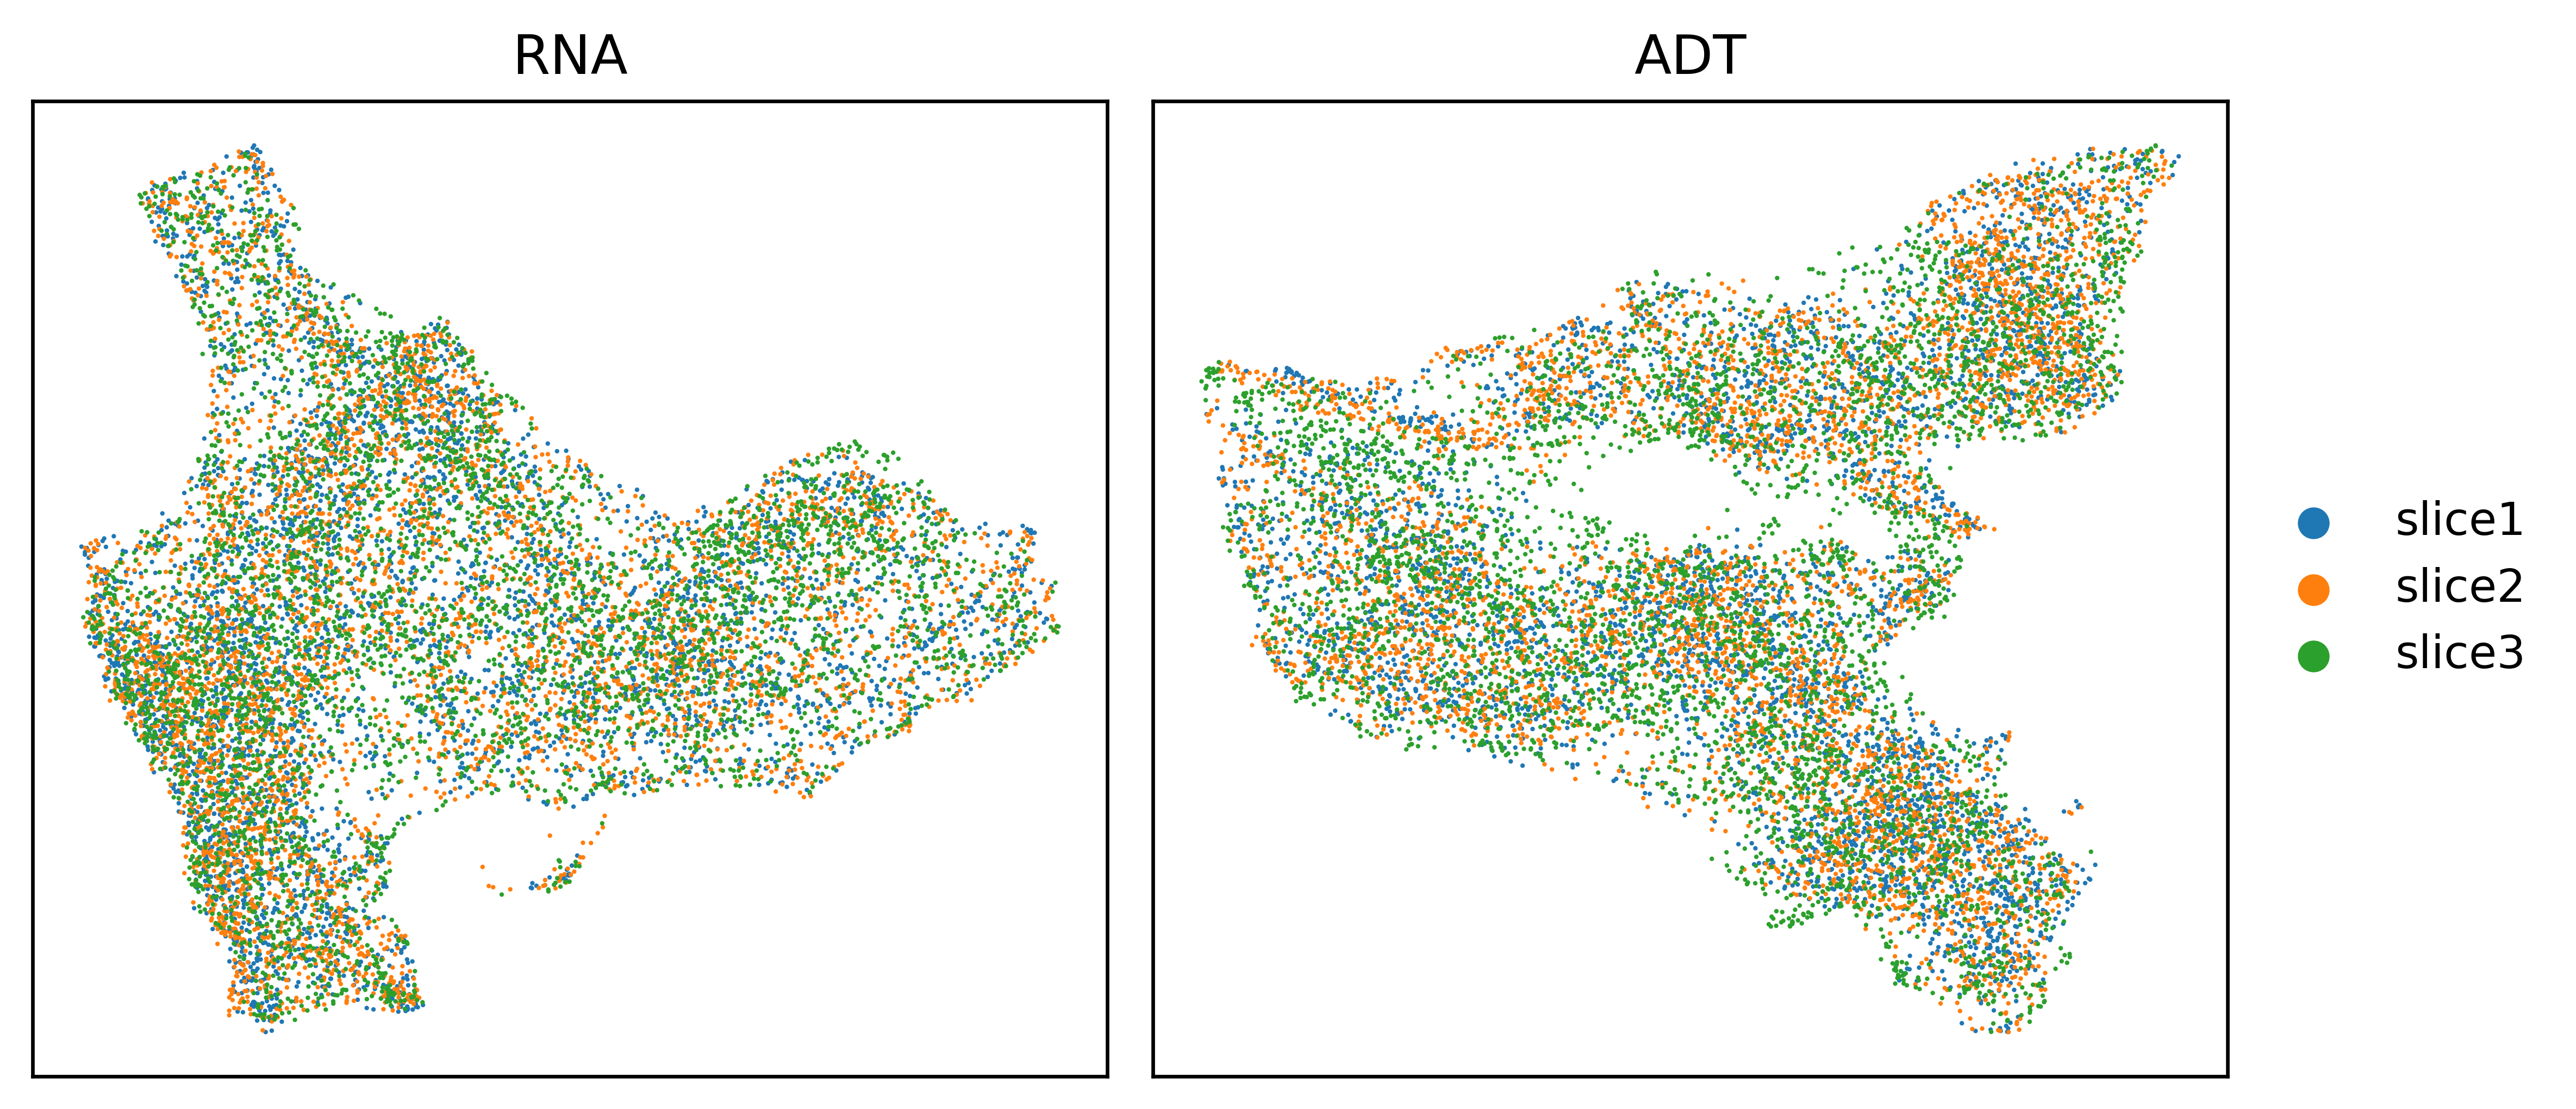

In [23]:
fig, ax_list = plt.subplots(1, 2, figsize=(8, 3.5),dpi=600)
sc.pp.neighbors(adata_RNA, use_rep='X_pca_harmony', n_neighbors=10)
sc.tl.umap(adata_RNA)
sc.pl.umap(adata_RNA, color='batch', ax=ax_list[0], title='RNA', s=4 ,show=False)
ax_list[0].get_legend().remove()
sc.pp.neighbors(adata_ADT, use_rep='X_pca_harmony', n_neighbors=10)
sc.tl.umap(adata_ADT)
sc.pl.umap(adata_ADT, color='batch', ax=ax_list[1], title='ADT', s=4, show=False)
ax_list[1].set_xlabel("")
ax_list[1].set_ylabel("")
ax_list[0].set_xlabel("")
ax_list[0].set_ylabel("")
plt.tight_layout(w_pad=1)
plt.show()

## MNN triplet samples calculation

In [24]:
adata_list=[adata_RNA,adata_ADT]
x = [torch.FloatTensor(adata.obsm["X_pca_harmony"]).to(device) for adata in adata_list]
triplet_samples_list = [MMN_batch(adata.obsm["X_pca_harmony"],adata.obs["batch"],far_frac=0.8,top_k=1) for adata in adata_list]

Batch slice1 vs slice2: 1128 MNN (top-1) triplets


Batch slice1 vs slice3: 1061 MNN (top-1) triplets
Batch slice2 vs slice3: 1081 MNN (top-1) triplets
Batch slice1 vs slice2: 1232 MNN (top-1) triplets
Batch slice1 vs slice3: 1049 MNN (top-1) triplets
Batch slice2 vs slice3: 995 MNN (top-1) triplets


## Model training

In [25]:
edges =[torch.LongTensor(adata.uns["edgeList"]).to(device) for adata in adata_list ]

model=train_SMART(features=x,
    edges=edges,
    triplet_samples_list=triplet_samples_list,
    weights=[1,1,1,1],
    emb_dim=32, 
    n_epochs=150,
    lr=0.005,
    weight_decay=1e-6,
    device = device,
    window_size=10,
    slope=0.0001
    )

adata_RNA.obsm["SMART"]=model(x, edges)[0].cpu().detach().numpy()

  0%|          | 0/150 [00:00<?, ?it/s]

 93%|█████████▎| 139/150 [00:08<00:00, 17.10it/s]


Stopping for flat trend


## Clustering

In [26]:
tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_RNA, key='SMART', add_key='SMART', n_clusters=6, method=tool, use_pca=True)
adata_RNA1=adata_RNA[~adata_RNA.obs['anno'].isna()]
ari = adjusted_rand_score(adata_RNA1.obs['anno'], adata_RNA1.obs["SMART"])
print(ari)

fitting ...
  |======================================================================| 100%
0.12223643733636311


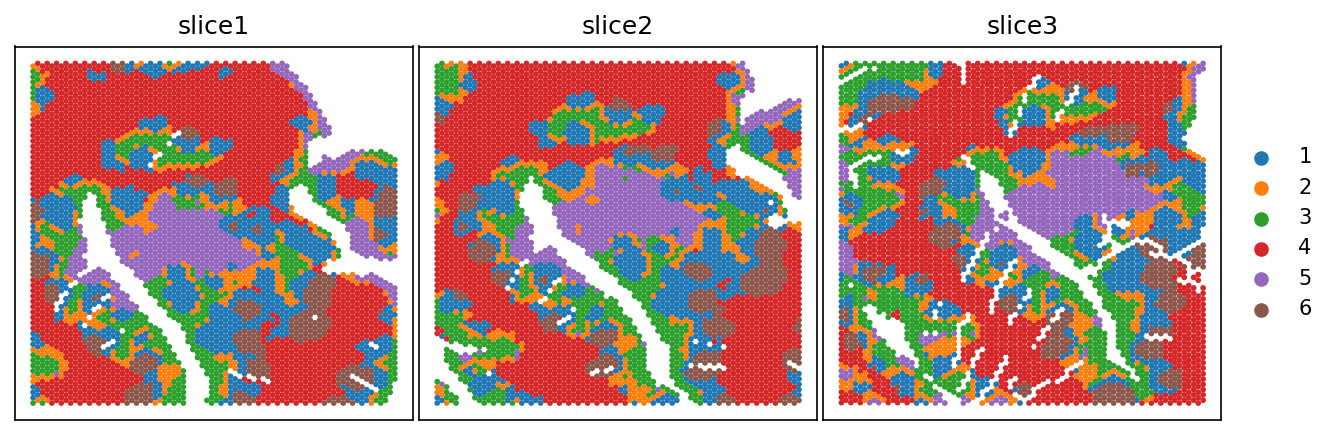

In [27]:
fig, ax_list = plt.subplots(1, 3, figsize=(9, 3),dpi=150)
sc.pl.embedding(adata_RNA[adata_RNA.obs["batch"]=="slice1"].copy(), basis='spatial', color='SMART', ax=ax_list[0], title='slice1', s=30, show=False)
sc.pl.embedding(adata_RNA[adata_RNA.obs["batch"]=="slice2"].copy(), basis='spatial', color='SMART', ax=ax_list[1], title='slice2', s=30, show=False)
sc.pl.embedding(adata_RNA[adata_RNA.obs["batch"]=="slice3"].copy(), basis='spatial', color='SMART', ax=ax_list[2], title='slice3', s=30, show=False)

ax_list[1].set_xlabel("")
ax_list[1].set_ylabel("")
ax_list[0].set_xlabel("")
ax_list[0].set_ylabel("")
ax_list[2].set_xlabel("")
ax_list[2].set_ylabel("")

ax_list[0].get_legend().remove()
ax_list[1].get_legend().remove()
plt.tight_layout(w_pad=0.3)
plt.show()